In [22]:
%matplotlib inline
from AxonDeepSeg.data import data_augmentation
from AxonDeepSeg.visualization.visualize import visualize_training
import json
import os
import os, shutil
from scipy.misc import imread, imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

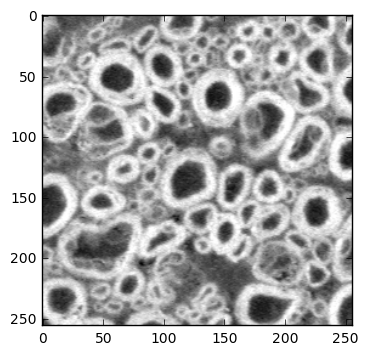

In [88]:
img = plt.imread('/Users/alzaia/Desktop/cnn_project/data_2_classes_gen/training/Train/image_78.png')
mask = plt.imread('/Users/alzaia/Desktop/cnn_project/data_2_classes_gen/training/Train/mask_78.png')
# plt.figure(figsize=(18,10))
plt.imshow(img, cmap='gray')

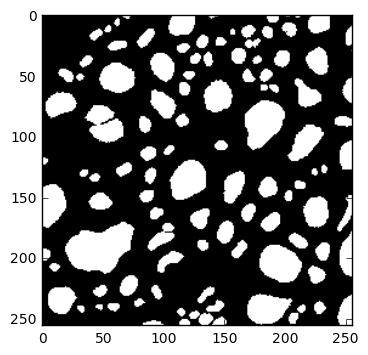

In [89]:
plt.imshow(mask, cmap='gray')

In [91]:
patch = [img,mask]

In [96]:
def shifting(patch):
    """
    :param patch: [image,mask]
    :return: random shifting of the pair [image,mask]
    """
    size_shift = 10
    img = np.pad(patch[0],size_shift, mode = "reflect")
    mask = np.pad(patch[1],size_shift, mode = "reflect")
    begin_h = np.random.randint(2*size_shift-1)
    begin_w = np.random.randint(2*size_shift-1)
    shifted_image = img[begin_h:begin_h+256,begin_w:begin_w+256]
    shifted_mask = mask[begin_h:begin_h+256,begin_w:begin_w+256]

    return [shifted_image,shifted_mask]



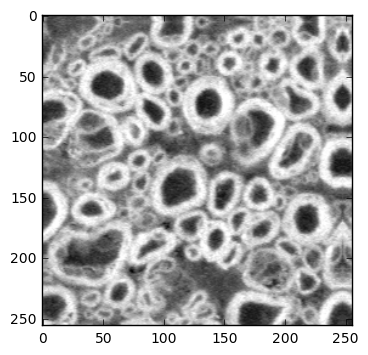

In [98]:
[shifted_image,shifted_mask] = shifting(patch)
plt.imshow(shifted_image, cmap='gray')

In [233]:
from skimage import exposure
from skimage.transform import rescale
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imread
from sklearn import preprocessing
from skimage import transform
from scipy import ndimage
import numpy as np
import random
import os
from AxonDeepSeg.data.patch_extraction import extract_patch

def rescaling(patch, thresh_indices = [0,0.5]): #indices to indexes.
    """
    :param patch:  [image,mask]
    :param thresh_indices : list of float in [0,1] : the thresholds for the ground truthes labels.
    :return: random rescaling of the pair [image,mask]

    --- Rescaling reinforces axons size diversity ---
    """

    scale = 2
#     scale = random.choice([0.5, 0.75, 1.0, 1.5, 2.0])

    if scale == 1.0:
        rescaled_patch = patch

    else :
        image_rescale = rescale(patch[0], scale, preserve_range= True)
        mask_rescale = rescale(patch[1], scale, preserve_range= True)
        s_r = mask_rescale.shape[0]
        q_h, r_h = divmod(256-s_r,2)

        if q_h > 0:
            image_rescale = np.pad(image_rescale,(q_h, q_h+r_h), mode = "reflect")
            mask_rescale = np.pad(mask_rescale,(q_h, q_h+r_h), mode = "reflect")
        else:           
            patches = extract_patch(image_rescale, mask_rescale, 256)
            i = np.random.randint(len(patches), size=1)[0]
            image_rescale, mask_rescale = patches[i]

        mask_rescale = np.array(mask_rescale)

        for indice,value in enumerate(thresh_indices[:-1]):
            if np.max(mask_rescale) > 1.001:
                thresh_inf = np.int(255*value)
                thresh_sup = np.int(255*thresh_indices[indice+1])
            else:
                thresh_inf = value
                thresh_sup = thresh_indices[indice+1]   

            mask_rescale[(mask_rescale >= thresh_inf) & (mask_rescale < thresh_sup)] = np.mean([value,thresh_indices[indice+1]])

        mask_rescale[(mask_rescale >= thresh_indices[-1])] = 1

#         rescaled_patch = [image_rescale.astype(np.uint8), mask_rescale]

    return image_rescale

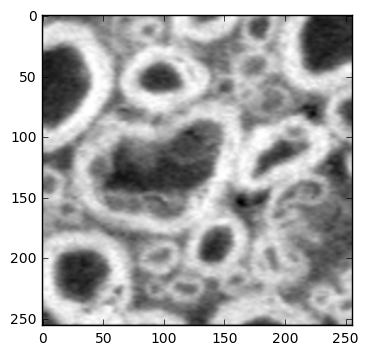

In [234]:
image_rescale = rescaling(patch, thresh_indices = [0,0.5])
plt.imshow(image_rescale, cmap='gray')

In [218]:
def random_rotation(patch, thresh_indices = [0,0.5]):
    """
    :param patch: [image, mask]
    :param thresh_indices : list of float in [0,1] : the thresholds for the ground truthes labels.
    :return: random rotation of the pair [image,mask]
    """
    img = patch[0]
    mask = patch[1]

    angle = 50
#     angle = np.random.uniform(5, 89, 1)

    image_rotated = transform.rotate(img, angle, resize = False, mode = 'symmetric',preserve_range=True)
    gt_rotated = transform.rotate(mask, angle, resize = False, mode = 'symmetric', preserve_range=True)

#     for indice,value in enumerate(thresh_indices[:-1]):
#         if np.max(gt_rotated) > 1.001:
#             thresh_inf = np.int(255*value)
#             thresh_sup = np.int(255*thresh_indices[indice+1])
#         else:
#             thresh_inf = value
#             thresh_sup = thresh_indices[indice+1]      
        
#         gt_rotated[(gt_rotated >= thresh_inf) & (gt_rotated < thresh_sup)] = np.mean([value,thresh_indices[indice+1]])
    
#     gt_rotated[gt_rotated >= thresh_sup] = 1

    return image_rotated


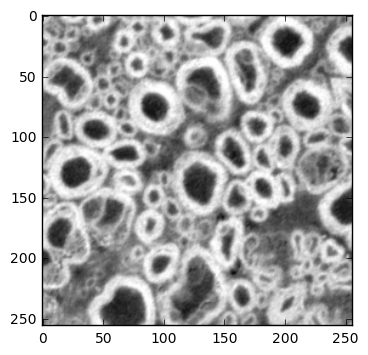

In [219]:
rot_patch = random_rotation(patch, thresh_indices = [0,0.5])
plt.imshow(rot_patch, cmap='gray')

In [235]:

def flipping(patch):
    """
    :param patch: [image,mask]
    :return: random vertical and horizontal flipped [image,mask]
    """
    s = np.random.binomial(1, 0.5, 1)
    image = patch[0]
    gt = patch[1]
    if s == 1 :
        image, gt = [np.fliplr(image), np.fliplr(gt)]
    s = np.random.binomial(1, 0.5, 1)
    if s == 1:
        image, gt = [np.flipud(image), np.flipud(gt)]
    return [image, gt]

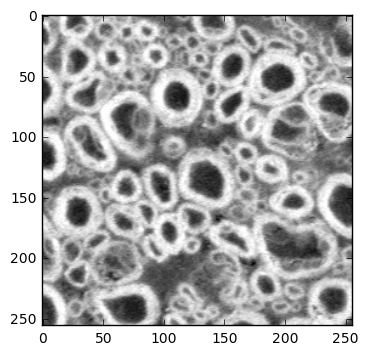

In [236]:
flip_patch = flipping(patch)
plt.imshow(flip_patch[0], cmap='gray')

In [296]:
def elastic_transform(image, gt, alpha, sigma, thresh_indices = [0,0.5]):
    """
    :param image: image
    :param gt: ground truth
    :param alpha: deformation coefficient (high alpha -> strong deformation)
    :param sigma: std of the gaussian filter. (high sigma -> smooth deformation)
    :param thresh_indices : list of float in [0,1] : the thresholds for the ground truthes labels.
    :return: deformation of the pair [image,mask]
    """

    random_state = np.random.RandomState(None)
    shape = image.shape

    d = 4
    sub_shape = (shape[0]/d, shape[0]/d)

    deformations_x = random_state.rand(*sub_shape) * 2 - 1
    deformations_y = random_state.rand(*sub_shape) * 2 - 1

    deformations_x = np.repeat(np.repeat(deformations_x, d, axis=1), d, axis = 0)
    deformations_y = np.repeat(np.repeat(deformations_y, d, axis=1), d, axis = 0)

    dx = gaussian_filter(deformations_x, sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter(deformations_y, sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    elastic_image = map_coordinates(image, indices, order=1).reshape(shape)
    elastic_gt = map_coordinates(gt, indices, order=1).reshape(shape)
    elastic_gt = np.array(elastic_gt)

    for indice,value in enumerate(thresh_indices[:-1]):
        if np.max(elastic_gt) > 1.001:
            thresh_inf = np.int(255*value)
            thresh_sup = np.int(255*thresh_indices[indice+1])
        else:
            thresh_inf = value
            thresh_sup = thresh_indices[indice+1]
        elastic_gt[(elastic_gt >= thresh_inf) & (elastic_gt < thresh_sup)] = np.mean([value,thresh_indices[indice+1]])

    elastic_gt[elastic_gt >= thresh_sup] = 1

    return [elastic_image, elastic_gt]

def elastic(patch, thresh_indices = [0,0.5]):
    """
    :param patch: [image,mask].
    :param thresh_indices : list of float in [0,1] : the thresholds for the ground truthes labels.
    :return: random deformation of the pair [image,mask].
    """
#     alpha = random.choice([1,2,3,4,5,6,7,8,9])
    patch_deformed = elastic_transform(patch[0],patch[1], alpha = 10, sigma = 4,thresh_indices = thresh_indices)
    return patch_deformed[0]

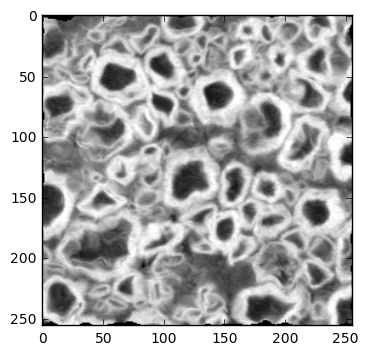

In [297]:
img_elastic = elastic([img,mask], thresh_indices = [0,0.5])
plt.imshow(img_elastic, cmap='gray')



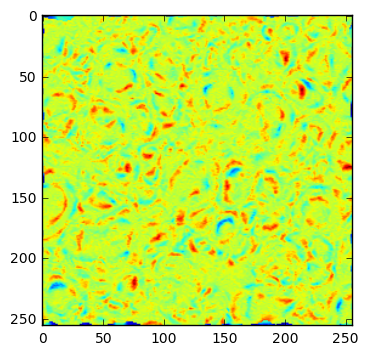

In [298]:
plt.imshow(img_elastic-img)

In [319]:
def noise_addition(patch):

    mu, sigma = 0, 0.2
    noise = np.random.normal(mu, sigma, [256,256])
    image = patch[0]
    img_noise = image+noise

    return [img_noise, patch[1]]

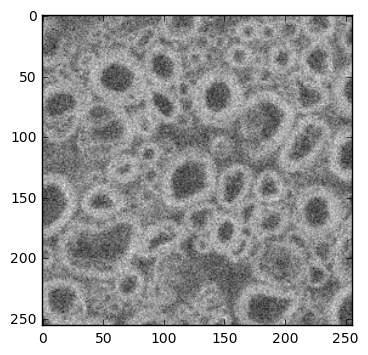

In [320]:
[img_noise, mask] = noise_addition(patch)
plt.imshow(img_noise, cmap='gray')


(256, 256)

In [331]:
def noise_multiplication(patch):

    mu, sigma = 1, 0.2
    noise = np.random.normal(mu, sigma, [256,256])
    image = patch[0]
    img_noise = image*noise

    return [img_noise, patch[1]]

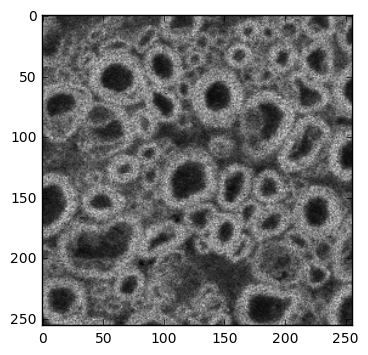

In [332]:
[img_noise2, mask] = noise_multiplication(patch)
plt.imshow(img_noise2, cmap='gray')

In [334]:
a=['a','b']
b = []
if not b:
    print('haha')

haha


In [335]:
if a:
    print('hehe')

hehe
